In [58]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import pairwise_distances, pairwise
import networkx as nx
import collections

In [59]:
adjacency = np.load("processed_data/coexpression_adjacency.npy")
graph = nx.from_numpy_matrix(adjacency)

In [60]:
adjacency.shape

(696, 696)

Verify that the adjacency matrix is symmetric

In [61]:
np.count_nonzero(adjacency - adjacency.transpose())

0

In [62]:
def num_edges(A):
    diag_edges = np.count_nonzero(np.diag(A))
    non_diag_sum = np.count_nonzero(A) - diag_edges # Sum of the entries of the matrix minus the trace
    return non_diag_sum /2 + diag_edges # Non diagonal entries are counted twice since the matrix is symmetric so they have to be divided by 2

In [63]:
edges = num_edges(adjacency)
possible_edges = len(adjacency) * (len(adjacency)-1)

print(f"Number of edges in the graph: {edges}")
print(f"Maximum possible number of edges: {possible_edges}")
print(f"Proportion of {edges/possible_edges}")

Number of edges in the graph: 15254.0
Maximum possible number of edges: 483720
Proportion of 0.031534772182254193


In [64]:
adjacency_discretized = adjacency.copy()
adjacency_discretized[adjacency_discretized > 0] = 1
degrees = np.sum(adjacency_discretized, axis=0)
deg_hist_normalization = np.ones(adjacency_discretized.shape[0]) / adjacency_discretized.shape[0]

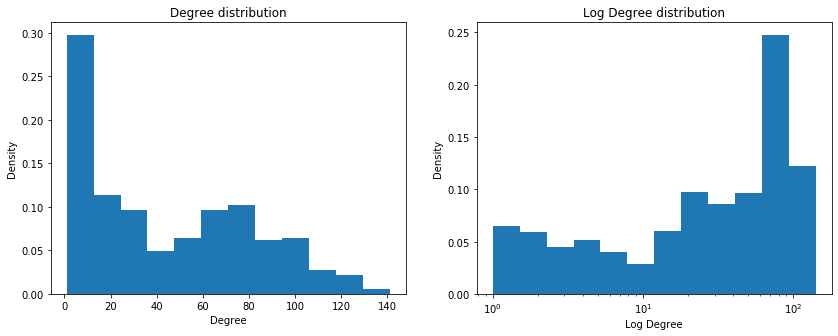

In [65]:
plt.figure(figsize=(14,5))

# histogram on linear scale
plt.subplot(121)
plt.title('Degree distribution')
plt.xlabel('Degree')
plt.ylabel('Density')
hist, bins, _ = plt.hist(degrees, weights=deg_hist_normalization, bins=12)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.subplot(122)
plt.title('Log Degree distribution')
plt.xlabel('Log Degree')
plt.ylabel('Density')
plt.hist(degrees, weights=deg_hist_normalization, bins=logbins)
plt.xscale('log')
plt.show()

In [66]:
np.max(degrees)

141.0

In [67]:
moment_1 = degrees.mean()
moment_2 = (degrees ** 2).mean() # 2nd Raw Moment

print(f"1st moment of graph: {moment_1}")
print(f"2nd moment of graph: {moment_2}")

1st moment of graph: 43.833333333333336
2nd moment of graph: 3281.864942528736


As we can see on the plot, the degree distribution is not heavy-tailed. That means that our graph does not have big hubs. We can verify this more precisely by checking the maximum degree of a node in our graph, and it is less than 5 times the average degree, which, given the size of the graph, is not enough to qualify as a hub.

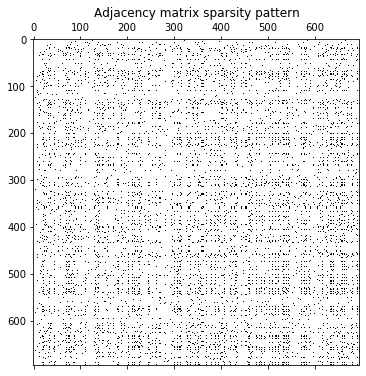

In [68]:
plt.figure(figsize=(6,6))
plt.spy(adjacency)
plt.title('Adjacency matrix sparsity pattern')
plt.show()

In [69]:
def paths(adj, N):
    P = np.zeros_like(adj)
    for i in range(0, N+1):
        P += np.linalg.matrix_power(adj, i)

    return P

In [70]:
path_matrix = paths(adjacency, 10)

In [71]:
def compute_diameter(adj):
    for i in range(0, len(adj)):
        P = paths(adj, i)
        if (np.sum(P <= 0) == 0):
            return i
    return -1

In [72]:
compute_diameter(adjacency)

16

In [73]:
print(f"Diameter according to networkx: {nx.diameter(graph)}")

Diameter according to networkx: 16


In [74]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # We apply the formulas from the lecture
    D = np.diag(np.sum(adjacency, axis=0))
    L = D - adjacency
    if normalize: 
        D2 = np.diag(np.sum(adjacency, axis=0) ** (-1/2))
        Ln = np.dot(np.dot(D2, L), D2)
        return Ln
    else:
        return L

In [75]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

In [76]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    e_values, e_vectors = np.linalg.eigh(laplacian)

    return e_values, e_vectors.T # We transpose the eigenvectors so that e_vectors[k] is the k-th eigenvector (instead of e_vectors[:, k])

In [77]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

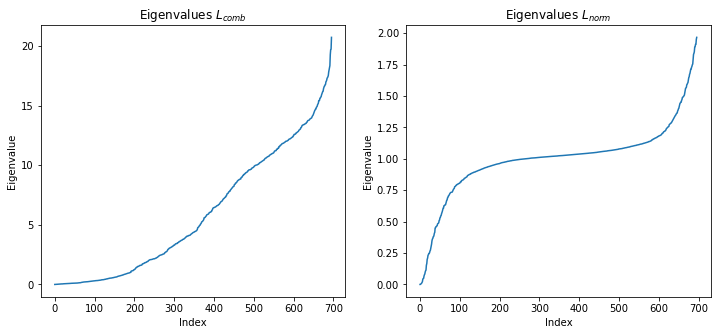

In [78]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [79]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    count = 0
    for i in range(len(lamb)):
        if lamb[i] <= threshold:
            # We count the number of eigenvalues close enough to zero (threshold takes into account the possible computationnal imprecisions)
            count += 1
    return count

In [80]:
print(compute_number_connected_components(lamb_norm, threshold=1e-12))

1


As expected, we only have 1 connected component.

In [81]:
print("The average clustering coefficient is", nx.average_clustering(graph))

The average clustering coefficient is 0.5832621152157117


In [82]:
nx.write_gexf(graph, "data/graph.gexf")